# Merit Award Project

## Setup

In [22]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics.pairwise import rbf_kernel
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, silhouette_score, silhouette_samples
from sklearn.mixture import GaussianMixture

### Load Data

In [23]:
data = load_breast_cancer()
X = data.data
y = data.target


### Split Data

In [24]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


### Scale Data

In [25]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Exercise 1 

In [26]:
logistic_reg = LogisticRegression(random_state=42, max_iter=3000)
logistic_reg.fit(X_train, y_train)

LogisticRegression(max_iter=3000, random_state=42)

In [27]:
test_acc = logistic_reg.score(X_test, y_test)
train_acc = logistic_reg.score(X_train, y_train)
print(test_acc)
print(train_acc)

0.9824561403508771
0.9874371859296482


# Exercise 2

In [28]:
k_range = range(2, 11)
train_silhouette_scores = list()
test_silhouette_scores = list()
em_model_per_k = list()

for k in k_range:
    em_model = GaussianMixture(n_components=k, random_state=10)
    em_model.fit(X_train)
    train_labels = em_model.predict(X_train)
    test_labels = em_model.predict(X_test)

    # Calculate silhouette score
    train_silhouette = silhouette_score(X_train, train_labels)
    test_silhouette = silhouette_score(X_test, test_labels)

    train_silhouette_scores.append(train_silhouette)
    test_silhouette_scores.append(test_silhouette)

    em_model_per_k.append(em_model)

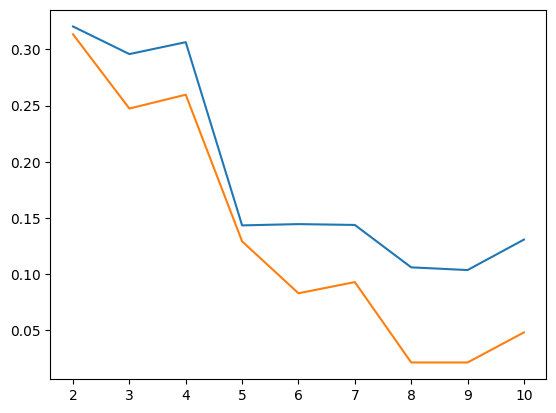

In [29]:
plt.plot(k_range, train_silhouette_scores)
plt.plot(k_range, test_silhouette_scores)
plt.show()

In [30]:
np.max(train_silhouette_scores), np.max(test_silhouette_scores)

(np.float64(0.3204081525954227), np.float64(0.31343739209195376))

In [31]:
optimal_k = 2
print(f"The Optimal K for the EM clustering algorithm is {optimal_k}")

The Optimal K for the EM clustering algorithm is 2


# Exercise 3

In [32]:
test_probas_per_k = []

for em_model in em_model_per_k:
    test_probas_per_k.append(em_model.predict_proba(X_test))


# Exercise 4

In [33]:
train_accuracies = list()
test_accuracies = list()

for test_probas in test_probas_per_k:
    lr = LogisticRegression(random_state=10)
    lr.fit(test_probas, y_test)
    y_pred = lr.score(test_probas, y_test)
    test_accuracies.append(y_pred)
    

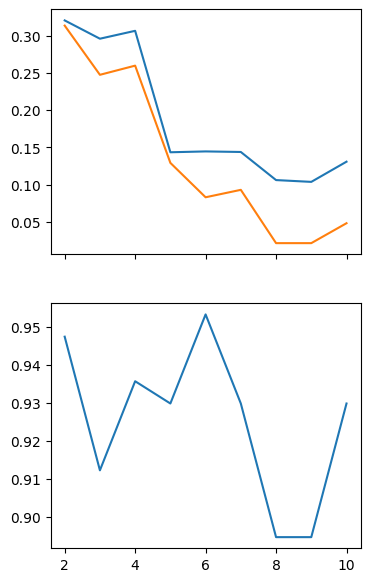

In [34]:
figure, (ax1, ax2) = plt.subplots(2, 1, sharex=1, figsize=(4, 7))
ax1.plot(k_range, train_silhouette_scores)
ax1.plot(k_range, test_silhouette_scores)
ax2.plot(k_range, test_accuracies)
plt.show()

Logistic Regression score with the optimal k = 2 

In [35]:
test_accuracies[0]

0.9473684210526315

In [36]:
len(X[0])

30

Upon analyzing the relationship between the number of clusters (k) and both performance metrics, the Silhouette scores and Logistic Regression accuracy on the mapped dataset, we observe a notable correlation in their behavior. The two metrics demonstrate similar trajectories, suggesting that the quality of clustering, as measured by the Silhouette score, directly influences the subsequent classification performance. Most significantly, both metrics show high values at k=2 and k=3, followed by a sharp decline as k increases. This sharp decline beyond k=3 indicates that additional clusters are likely to be unnecessary, theerefore leading to lower silhouette scores and classification accuracy. Using k=2 or k=3 the EM algorithm effectively serves as a dimensionality reduction technique, transforming the original high-dimensional feature space (30 features) into a lower dimensional feature space, while maintaining a high accuracy on the logistic regression.

# 5

The rbf network typically consists of 3 layers, the input layer,  a hidden layer with a non-linear RBF activation function and a linear output layer. Sklearn's MLPs doesn't have the kind of activation for rbf, so the following will convert the dataset to rbf features and then train a MLPRegressor corresponding to the output layer

We will use the mean centroids of each cluster (k=2) and the most popular kind of rbf: Gaussian rbf to perform a classification on the mapped dataset

### Optain Optimal model with k=2

In [37]:
optimal_k = 2
optimal_em_model: GaussianMixture = em_model_per_k[k_range.index(optimal_k)]

### Train rbf network

Best gamma for Gaussian: 0.499
Best accuracy: 0.631578947368421%


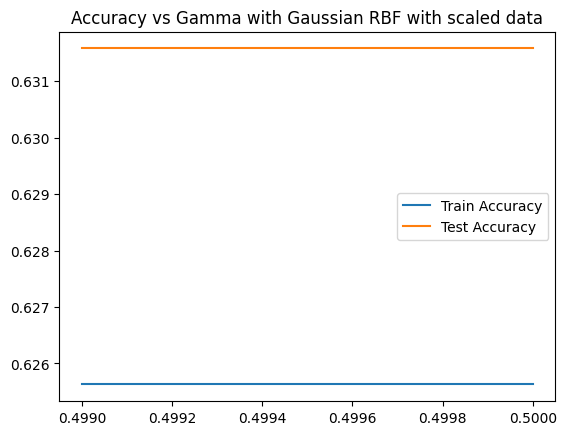

np.float64(0.027823400457701115)

In [42]:

from sklearn.neural_network import MLPClassifier
k = 2
gammas = [x/1000 for x in range(1, 501)]

from math import sqrt
rbf_functions = {
  "Gaussian": lambda gamma, x_t, means, covar : np.exp(-gamma*np.transpose(x_t - means) @ np.linalg.inv(covar) @ (x_t - means)),
  "Inverse quadratic": lambda gamma, x_t, means, covar : 1/(1+gamma**2*np.transpose(x_t - means) @ np.linalg.inv(covar) @ (x_t - means)),
  "Inverse multiquadric": lambda gamma, x_t, means, covar : 1/sqrt(1+gamma**2*np.transpose(x_t - means) @ np.linalg.inv(covar) @ (x_t - means))
}
test_accuracies = {key: [] for key in rbf_functions.keys()}
train_accuracies = {key: [] for key in rbf_functions.keys()}
X_rbf_list = []

rbf = "Gaussian"
# for rbf in rbf_functions.keys():
for gamma in gammas:
  em_model = em_model_per_k[k_range.index(k)]
  def get_rbf(X_old):
    X_new = []
    for x_t in X_old:
      new_x = []
      for means, covar in zip(em_model.means_, em_model.covariances_):
        new_x.append(rbf_functions[rbf](gamma, x_t, means, covar))
        # new_x.append(np.exp(-gamma*np.transpose(x_t - means) @ 
        #     np.linalg.inv(covar) @ (x_t - means)))
      X_new.append(new_x)
    return np.array(X_new)

  X_train_rbf = get_rbf(X_train)
  X_rbf_list.append(X_train_rbf)
  X_test_rbf  = get_rbf(X_test)

  rbf_network = LogisticRegression(random_state=42, max_iter=10000)
  rbf_network.fit(X_train_rbf, y_train)
  if k == 10:
    print(rbf_network.predict(X_train_rbf))
  train_accuracies[rbf].append(rbf_network.score(X_train_rbf, y_train))
  test_accuracies[rbf].append(rbf_network.score(X_test_rbf, y_test))

plt.plot(gammas, train_accuracies[rbf], label="Train Accuracy")
plt.plot(gammas, test_accuracies[rbf], label="Test Accuracy")
plt.legend()
plt.title(f"Accuracy vs Gamma with {rbf} RBF with scaled data")
print(f"Best gamma for {rbf}: {gammas[test_accuracies[rbf].index(max(test_accuracies[rbf]))]}")
print(f"Best accuracy: {max(test_accuracies[rbf])}%")
plt.show()
max(X_train_rbf.flatten())

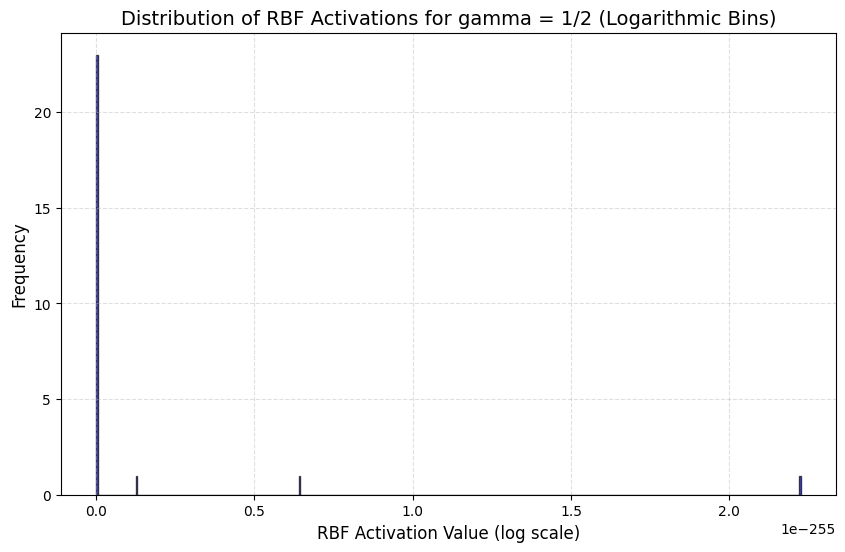

In [57]:
flat_rbf_activations = X_train_rbf.flatten()

# Plot the distribution of activations with logarithmic bins


plt.figure(figsize=(10, 6))

plt.hist(X_train_rbf[15].flatten(), bins=500, color='blue', alpha=0.7, edgecolor='black')

plt.title('Distribution of RBF Activations for gamma = 1/2 (Logarithmic Bins)', fontsize=14)

plt.xlabel('RBF Activation Value (log scale)', fontsize=12)

plt.ylabel('Frequency', fontsize=12)

plt.grid(alpha=0.4, which="both", linestyle="--")

plt.show()

In [16]:
X_train_rbf

array([[7.03458738e-006, 1.15252668e-001, 0.00000000e+000, ...,
        8.06576210e-076, 0.00000000e+000, 0.00000000e+000],
       [3.66760612e-008, 7.36199653e-002, 0.00000000e+000, ...,
        6.74941010e-089, 0.00000000e+000, 0.00000000e+000],
       [1.27798433e-006, 4.51403126e-008, 0.00000000e+000, ...,
        8.82123796e-059, 0.00000000e+000, 0.00000000e+000],
       ...,
       [5.94993778e-007, 8.74194404e-003, 0.00000000e+000, ...,
        2.29651465e-074, 0.00000000e+000, 0.00000000e+000],
       [2.36001269e-004, 3.40925885e-005, 0.00000000e+000, ...,
        1.62271288e-080, 0.00000000e+000, 0.00000000e+000],
       [4.69042811e-015, 1.72055310e-001, 0.00000000e+000, ...,
        4.88281315e-168, 0.00000000e+000, 0.00000000e+000]])

In [17]:
optimal_em_model.n_components

2

In [108]:
import numpy as np
from scipy.spatial.distance import mahalanobis

train_scores = list()
for em_model in em_model_per_k:
    means = em_model.means_
    covariances = em_model.covariances_
    n_components = em_model.n_components
    n_samples = X_train.shape[0]

    rbf_features = np.zeros((n_samples, n_components))

    for i in range(n_samples):
        for k in range(n_components):
            diff = X_train[i] - means[k]
            inv_cov = np.linalg.inv(covariances[k])
            mahal_dist_sq = np.dot(diff.T, np.dot(inv_cov, diff))

            # Apply the RBF formula
            rbf_features[i, k] = np.exp(-0.01 * mahal_dist_sq)

    rbf_network = LogisticRegression(random_state=42, max_iter=10000)
    rbf_network.fit(rbf_features, y_train)
    train_scores.append(rbf_network.score(rbf_features, y_train))

In [109]:
train_scores[0]

0.8919597989949749

In [103]:
rbf_network.score(rbf_features, y_train)

0.9271356783919598

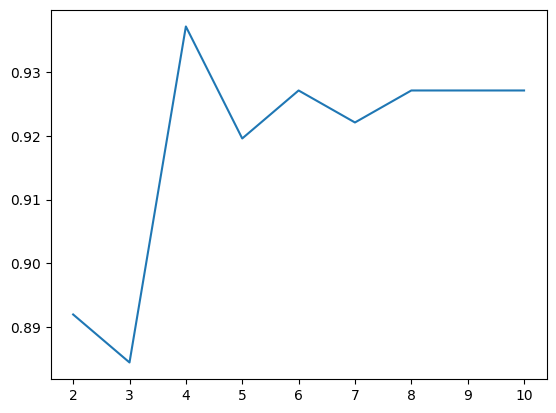

In [104]:
plt.plot(k_range, train_scores)
plt.show()

In [110]:
import numpy as np
from scipy.spatial.distance import mahalanobis

train_scores = list()
for em_model in em_model_per_k:
    means = em_model.means_
    covariances = em_model.covariances_
    n_components = em_model.n_components
    n_samples = X_train.shape[0]

    rbf_features = np.zeros((n_samples, n_components))

    for i in range(n_samples):
        for k in range(n_components):
            diff = X_train[i] - means[k]
            inv_cov = np.linalg.inv(covariances[k])
            mahal_dist_sq = np.dot(diff.T, np.dot(inv_cov, diff))

            # Apply the RBF formula
            rbf_features[i, k] = -0.5 * mahal_dist_sq

    rbf_network = LogisticRegression(random_state=42, max_iter=10000)
    rbf_network.fit(rbf_features, y_train)
    train_scores.append(rbf_network.score(rbf_features, y_train))

In [111]:
train_scores[0]

0.9170854271356784

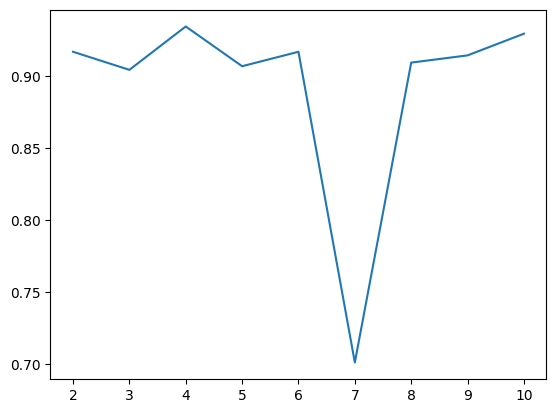

In [50]:
plt.plot(k_range, train_scores)
plt.show()